In [1]:
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
labels = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
# remove duplicates
labels = labels.drop_duplicates("patientId")

In [5]:
# paths for data directories 
ROOT_PATH = Path('../input/rsna-pneumonia-detection-challenge/stage_2_train_images')
SAVE_PATH = Path('./processed')

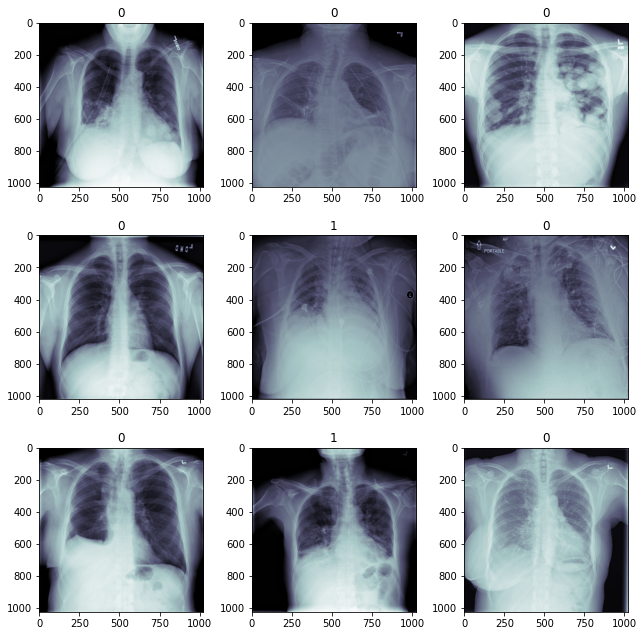

In [6]:
# plot example images
fig, axis = plt.subplots(3, 3, figsize=(9,9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels['Target'].iloc[c]
        
        axis[i][j].imshow(dcm, cmap='bone')
        axis[i][j].set_title(label)
        c+=1
        
plt.tight_layout()

In [7]:
# preprocessing
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
        
    patient_id = labels.patientId.iloc[c]

    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float64)
    
    label = labels.Target.iloc[c]
    
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)
    
    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array**2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [8]:
mean = sums / 24000
std = np.sqrt((sums_squared/24000) - mean**2)

mean, std

(0.49039743300942934, 0.2479450249418564)

In [9]:
def load_files(path):
    return np.load(path).astype(np.float32)

In [10]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,49, 0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,49, 0.248)
])

In [11]:
train_dataset = torchvision.datasets.DatasetFolder('./processed/train', loader=load_files, 
                                                   extensions="npy", transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder('./processed/val', loader=load_files, 
                                                   extensions="npy", transform=val_transforms)

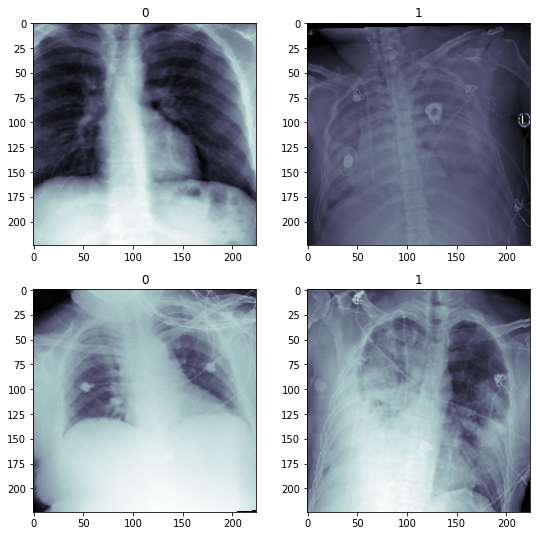

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(label)

In [13]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                         num_workers=num_workers, shuffle=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# check if dataset in imbalanced - awaited loss or oversampling to overcome imbalanced dataset
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [15]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# model class
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        
        # make necessary changes in the model layers
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss

    def training_epoch_end(self, outs):
        self.log("Train ACC", self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))
        
    def validation_epoch_end(self, outs):
        self.log("Val ACC", self.val_acc.compute())
        
    def configure_optimizers(self):
        return [self.optimizer]

In [17]:
model = PneumoniaModel()

In [18]:
# training and validation
checkpoint_callback = ModelCheckpoint(
    monitor="Val ACC", 
    save_top_k=10,
    mode="max")

In [26]:
accelerator = "gpu"
devices = 1 if torch.cuda.is_available() else None


trainer  = pl.Trainer(accelerator=accelerator, devices=devices, logger=TensorBoardLogger(save_dir="./logs"), 
                      log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=35)

In [27]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [46]:
# evaluation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt")
# model = PneumoniaModel.load_from_checkpoint("weights/weights_1.ckpt")

model.eval()
model.to(device);

In [32]:
preds = []
labels = []

with torch.no_grad():
    for data, label  in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
        
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [34]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix: \n{cm}")

Val Accuracy: 0.7865126729011536
Val Precision: 0.5164270997047424
Val Recall: 0.831404983997345
Confusion Matrix: 
tensor([[1608,  471],
        [ 102,  503]])


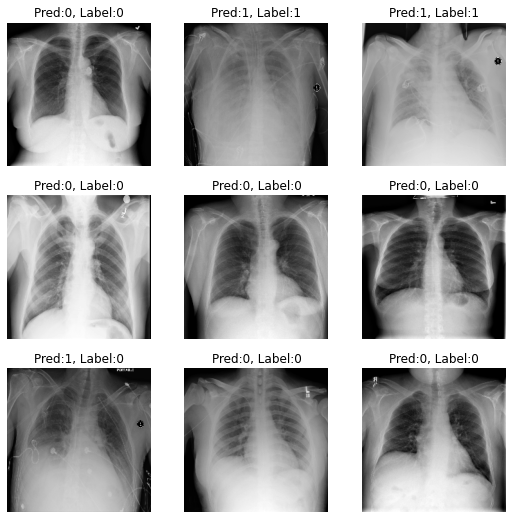

In [47]:
fig, axis = plt.subplots(3, 3, figsize=(9,9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="gray")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

In [115]:
# interpretability - Class Activation Maps
%matplotlib inline 

In [116]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [117]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),
])

val_dataset = torchvision.datasets.DatasetFolder("./processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [118]:
temp_model = torchvision.models.resnet18()

In [119]:
# len(list(temp_model.children()))

In [120]:
# list(temp_model.children())[:-2]

In [121]:
# torch.nn.Sequential(*list(temp_model.children())[:-2])

In [122]:
class PneumoModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1,1))
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flattened)
        return pred, feature_map

In [123]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
        
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7,7).cpu()
    
    return cam_img, torch.sigmoid(pred)

In [124]:
model = PneumoModel.load_from_checkpoint("../input/rsna-weights/weights_3.ckpt", strict=False)
model.eval();

In [127]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred > 0.5)
    

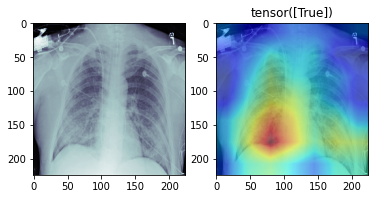

In [128]:
img = val_dataset[-6][0]

activation_map, pred = cam(model, img)

visualize(img, activation_map, pred)

<IPython.core.display.Javascript object>